In [1]:
!pip freeze

annotated-types==0.6.0
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
beautifulsoup4==4.12.3
bleach==6.1.0
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.5
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
executing==2.0.1
fastjsonschema==2.19.1
fonttools==4.51.0
fqdn==1.5.1
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
ibm-cloud-sdk-core==3.20.0
ibm-platform-services==0.53.6
idna==3.7
ipykernel==6.29.4
ipython==8.24.0
ipywidgets==8.1.2
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.3
json5==0.9.25
jsonpointer==2.4
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.1
jupyter_core==5.7.2
jupyter_server==2.14.0
jupyter_server_terminals==0.5.3
jupyterlab==4.1.8
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.1
jupyt

In [2]:
!python --version

Python 3.11.3


In [3]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_qc = pm.run(qc)
 
# You can use a fixed seed to get fixed results. 
options = {"simulator": {"seed_simulator": 42}}
sampler = Sampler(backend=fake_manila, options=options)
 
result = sampler.run([isa_qc]).result()

/home/nemo/Software/Quantencomputer/venv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:357: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


In [4]:
result

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)))], metadata={})

In [5]:
# General imports
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [6]:
# fake backend
backend = fake_manila
backend.name

'fake_manila'

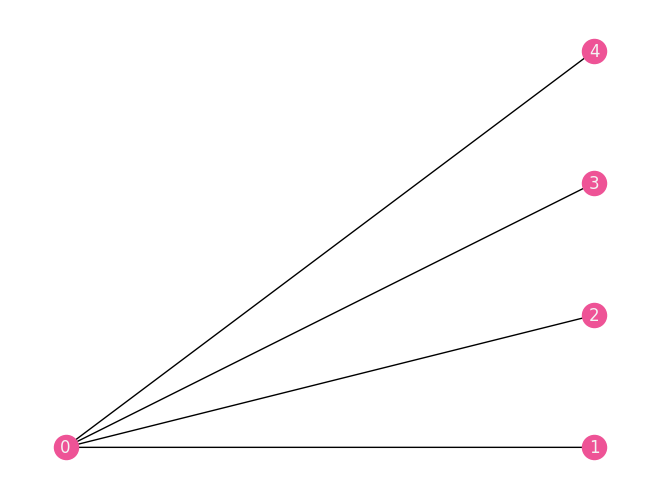

In [7]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

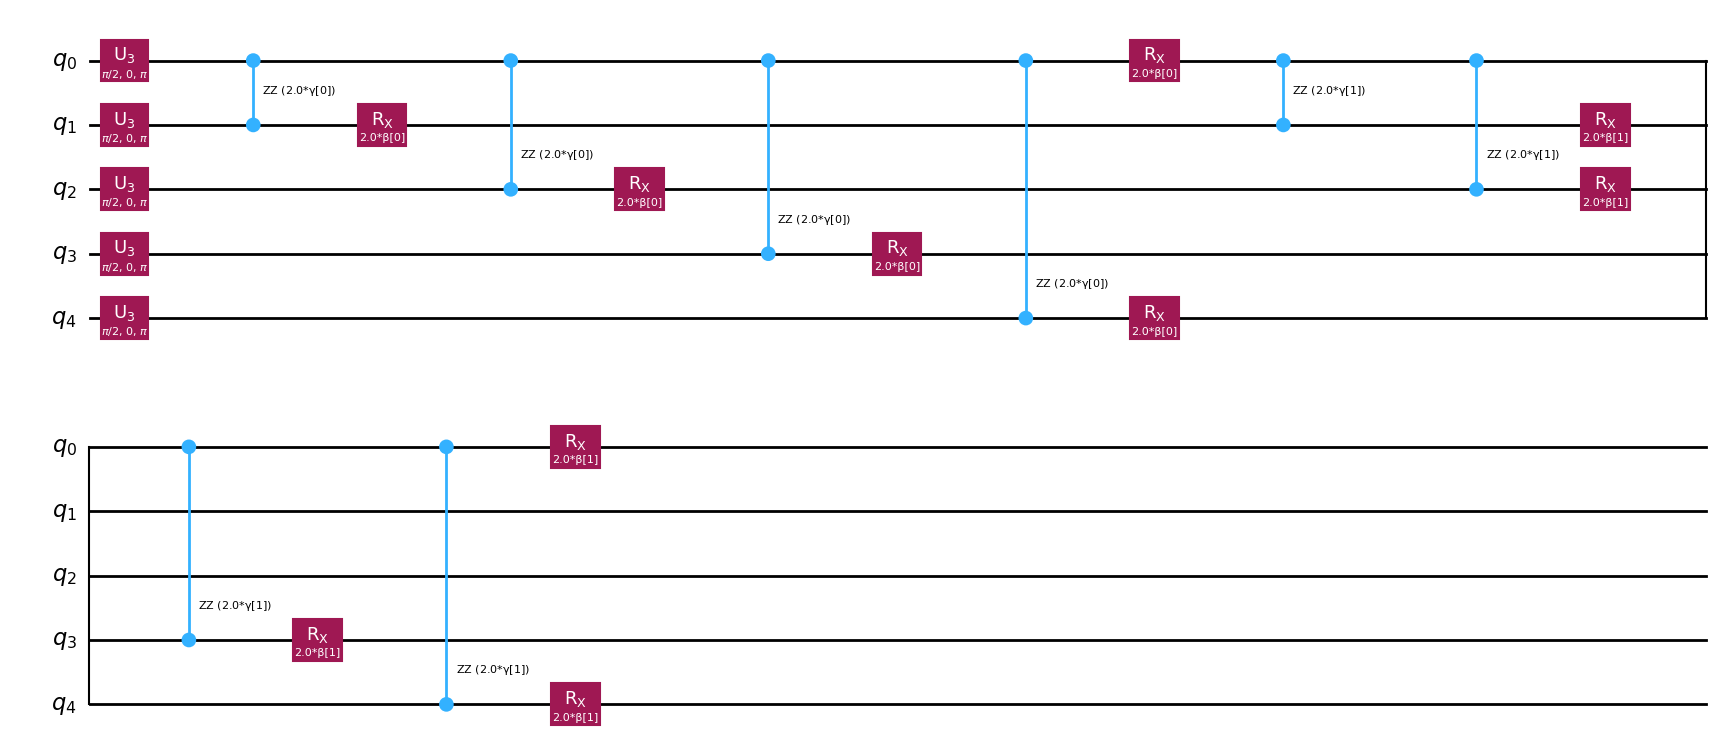

In [8]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

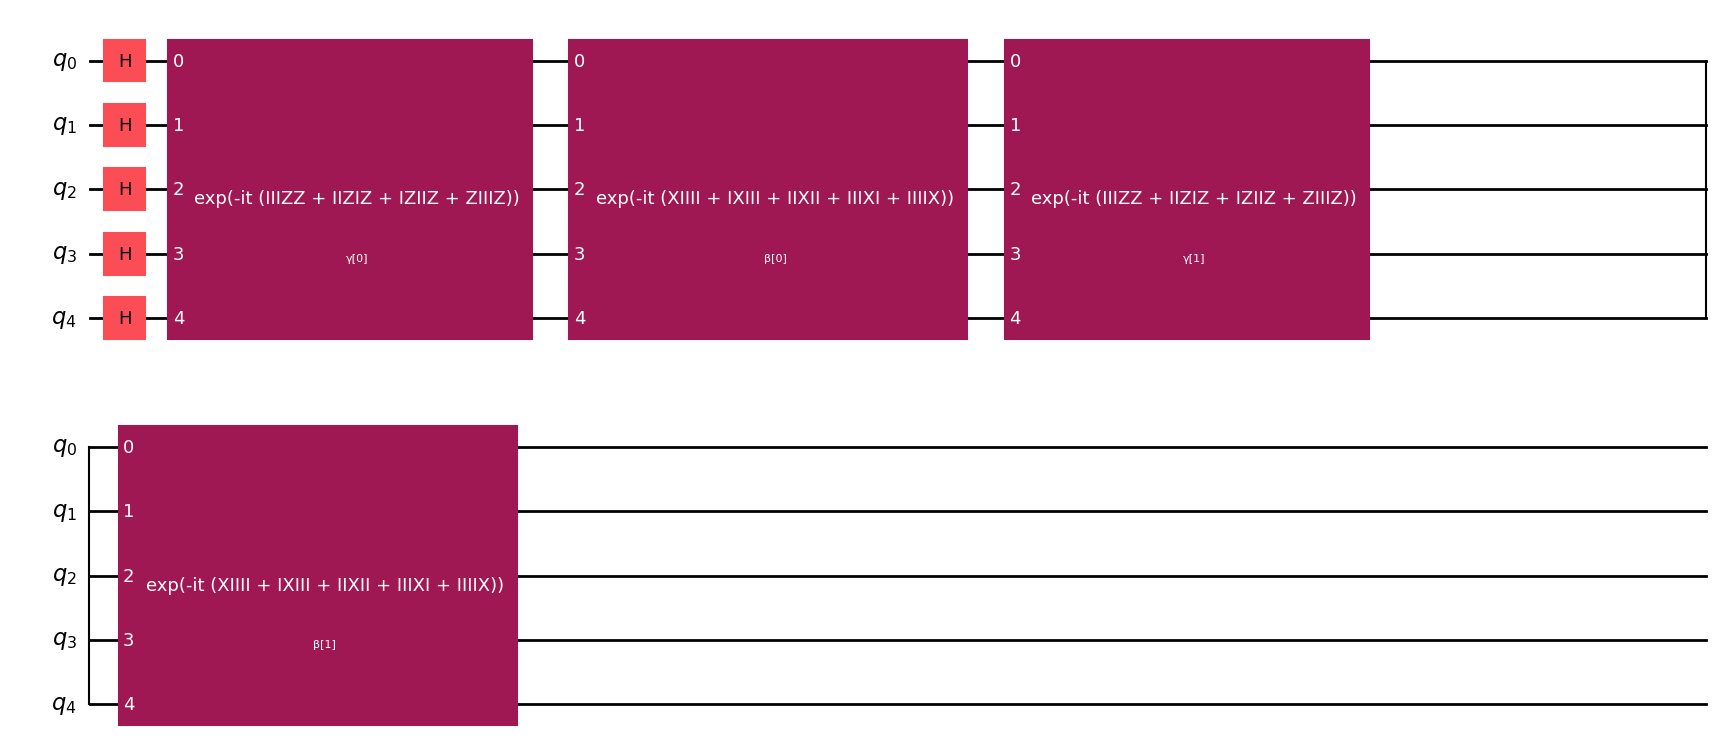

In [9]:
ansatz.decompose().draw(output="mpl", style="iqp")

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

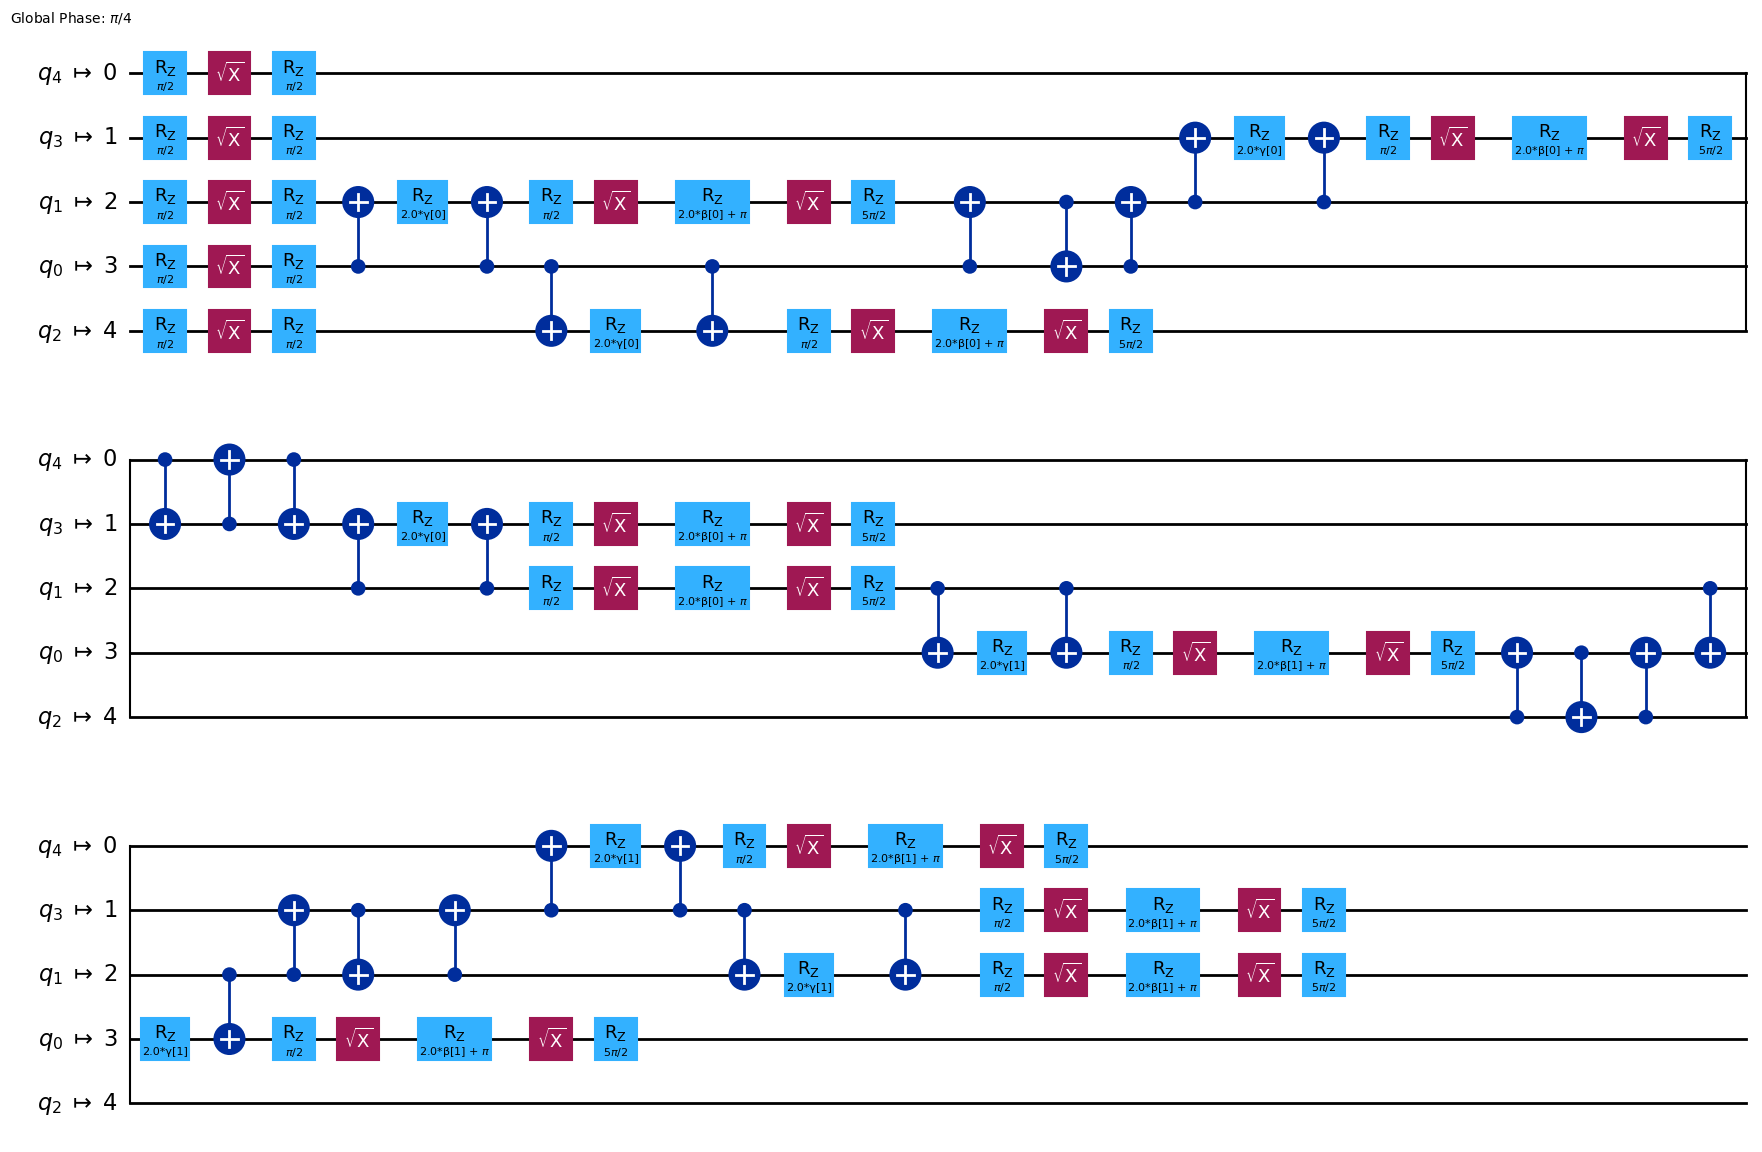

In [11]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [12]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['ZIIZI', 'IZIZI', 'IIIZZ', 'IIZZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [14]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

In [15]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [16]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [17]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.935546875
       x: [ 4.294e+00  5.106e+00  3.839e+00  1.583e+00]
    nfev: 55
   maxcv: 0.0

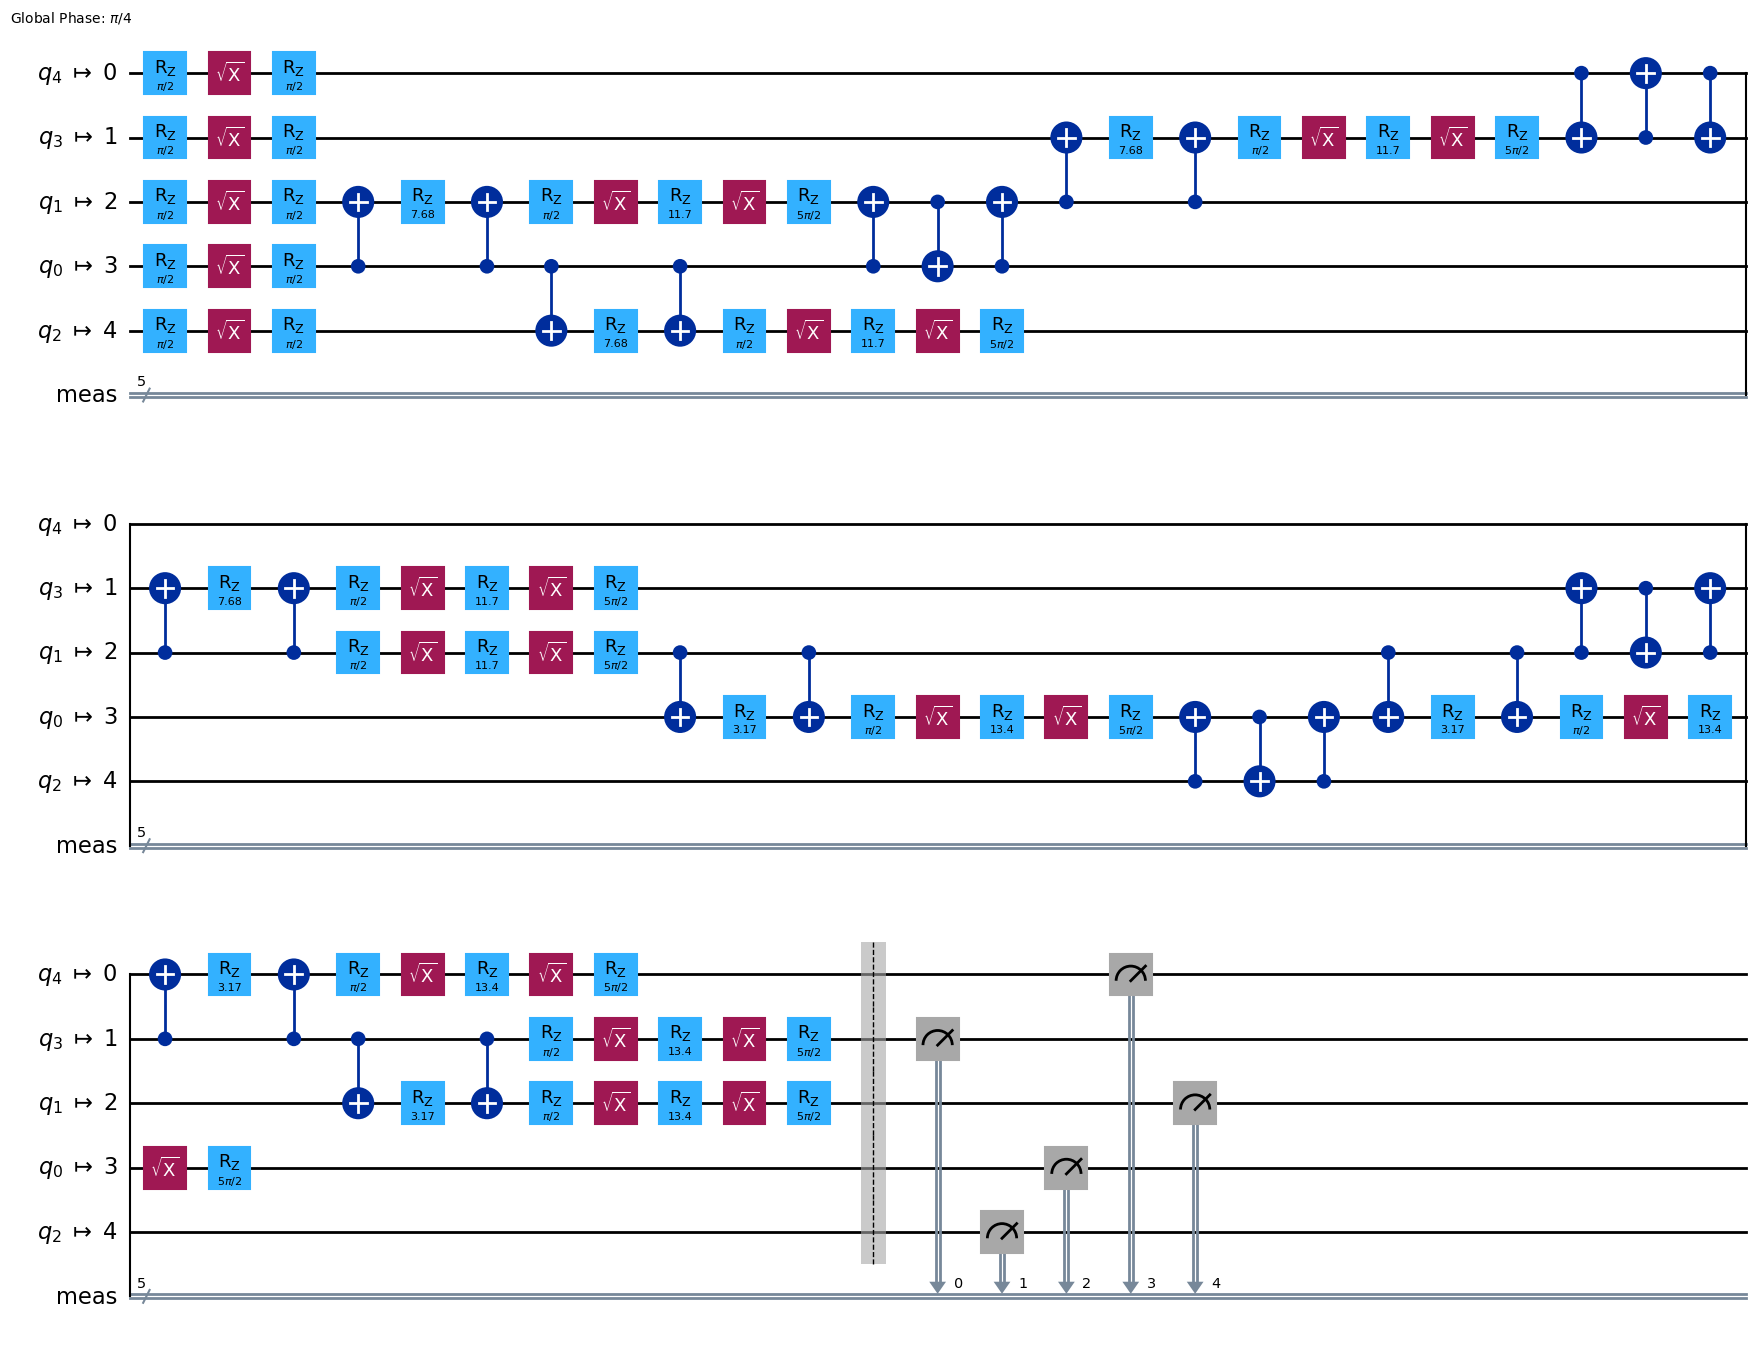

In [18]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [19]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

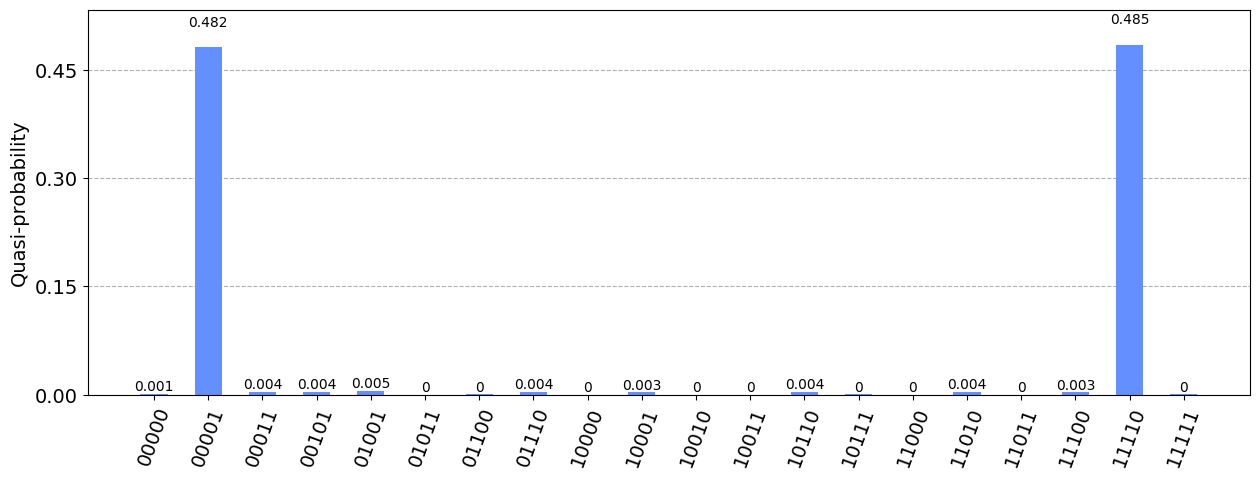

In [20]:
plot_distribution(samp_dist, figsize=(15, 5))

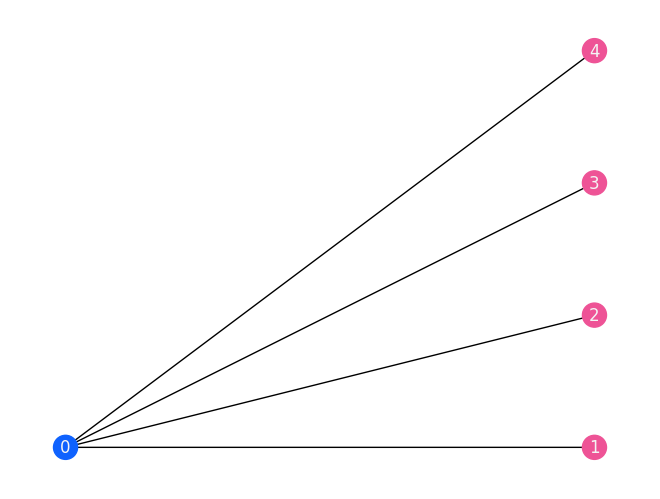

In [21]:
# Reverse 11110 to convert quantum result to classical solution
solution = [0, 1, 1, 1, 1]

mpl_draw(
    G,
    pos=rx.bipartite_layout(G, {0}),
    with_labels=True,
    node_color=["#EE5396" if kk else "#0F62FE" for kk in solution],
    font_color="#F4F4F4",
)

In [22]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [23]:
import qiskit

qiskit.version.get_version_info()

'1.0.2'